In [104]:
using JuMP
using Cbc, Ipopt
using Random
using LinearAlgebra
using ForwardDiff
using Plots, LaTeXStrings
pyplot(size=(325,325))

∇(f, x) = ForwardDiff.gradient(f, x)
D(θ, λ) = ForwardDiff.derivative(θ, λ)

D (generic function with 1 method)

In [105]:
function bisection_ls(f, a, b, l=1e-6)
    bᵢ = b
    aᵢ = a
    λ = 0
    while bᵢ - aᵢ > l
        λ = (aᵢ + bᵢ)/2
        ∇f= ForwardDiff.derivative(f,λ)
        if abs(∇f) < l # equivalent to ∇f = 0
            return λ
        elseif ∇f > 0 # left move
            aᵢ₊₁ = aᵢ
            bᵢ₊₁ = λ
        else # move right
            aᵢ₊₁ = λ
            bᵢ₊₁ = bᵢ
        end
        aᵢ = aᵢ₊₁
        bᵢ = bᵢ₊₁
        #println("interval=[", aᵢ, " ",bᵢ, "]")
    end
        return λ
end;

function armijo_ls(θ, λ, α, β, λbar)
    θ₀  = θ(0)                                 # Function value at zero
    Dθ₀ = D(θ, 0)                              # Derivative (slope) at zero
    while (θ(λ) > θ₀ + α*λ*Dθ₀) && (λ <= λbar) # Check termination condition
        λ = β*λ                                # Reduce λ until condition is satisfied
    end
    return λ
end

function FW(f, A, b; exact_ls=true)

    # Constants
    λbar = 1.0            # Upper bound of λ in FW method
    λ    = λbar           # Initial step size λ
    eps  = 1e-4           # Convergence tolerance

    # Armijo parameters
    α   = 0.01
    β   = 0.70

    # Objective function to be minimized
#     f(x) = exp(-(x[1]-3)/2) + exp((4x[2] + x[1] - 20)/10) + exp((-4x[2] + x[1])/10)
    ∇f(x) = ∇(f,x)
#     A = [2 3;
#          1 4]
#     b = [8; 6]

    # Initial values
    xᵏ  = [0; 0]
    traj = zeros(2,50)
    traj[:,1] = xᵏ
    # Compute x̄ᵏ from x̄ᵏ = argmin{x ∈ ℜⁿ : ∇f(xᵏ)ᵀx, x ∈ S}
    model = Model()
    set_optimizer(model, Cbc.Optimizer)
    @variable(model, x[1:2] >= 0)
    @constraint(model, A * x .<= b)
    @objective(model, Min, dot(∇(f, xᵏ), (x - xᵏ)))
    set_silent(model)
    optimize!(model)
    x̄ᵏ = value.(x)
    dᵏ = x̄ᵏ - xᵏ

    # Iteration counter + 1st solution
    k   = 1
    xᵏ  = xᵏ + λ*dᵏ
    traj[:,k+1] = xᵏ
    while abs(dot(∇(f, xᵏ), dᵏ)) > eps

        # Compute x̄ᵏ from x̄ᵏ = argmin{x ∈ ℜⁿ : ∇f(xᵏ)ᵀx, x ∈ S}
        model = Model()
        set_optimizer(model, Cbc.Optimizer)
        @variable(model, x[1:2] >= 0)
        @constraint(model, A * x .<= b)
        @objective(model, Min, dot(∇(f, xᵏ), (x - xᵏ)))
        set_silent(model)
        optimize!(model)
        x̄ᵏ = value.(x)
        dᵏ = x̄ᵏ - xᵏ

        # Line search
        θ(λ) = f(xᵏ + λ*dᵏ)
        
        if exact_ls
            λ = bisection_ls(θ, 0.0, λbar)
        else
            λ = armijo_ls(θ, λ, α, β, λbar)
        end    
        
        # Update solution
        k  = k + 1
        xᵏ = xᵏ + λ*dᵏ
        traj[:,k+1] = xᵏ
        println("residual: ", round(dot(∇(f, xᵏ), dᵏ), digits=5), " / iter: ", k)
    end

    # Get optimal cost
    obj = f(xᵏ)
    return (k, xᵏ, obj, traj[:,1:k+1])
end

FW (generic function with 1 method)

In [106]:
f(x) = exp(-(x[1]-3)/2) + exp((4x[2] + x[1] - 20)/10) + exp((-4x[2] + x[1])/10)
# ∇f(x) = ∇(f,x)
A = [2 3;
     1 4]
b = [8; 6]


## Solve model
(k, xsol, obj, traj) = FW(f, A, b)

## Print solution
println("  Iterations: ", k)
println("Optimal cost: ", round(obj, digits = 2))
println(traj)

Presolve 2 (0) rows, 2 (0) columns and 4 (0) elements
0  Obj 0 Dual inf 3.5368322 (2)
1  Obj -8.509244
Optimal - objective value -8.509244
Optimal objective -8.509244027 - 1 iterations time 0.002
residual: 0.0 / iter: 2
  Iterations: 2
Optimal cost: 2.24
[0.0 4.0 3.420393371582031; 0.0 0.0 0.3864044189453125]
Presolve 2 (0) rows, 2 (0) columns and 4 (0) elements
0  Obj 0 Dual inf 0.71681088 (2)
2  Obj -0.787678
Optimal - objective value -0.787678
Optimal objective -0.7876780007 - 2 iterations time 0.002


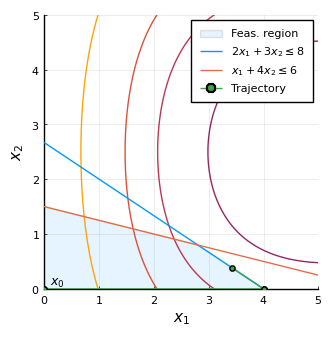

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [107]:
# Plotting

# Plotting the contours of the function optimised and the trajectory
f(x) = exp(-(x[1]-3)/2) + exp((4x[2] + x[1] - 20)/10) + exp((-4x[2] + x[1])/10)
# For validation
A = [2 3;
     1 4]
b = [8; 6]

n = 1000
x = range(-20,stop=20,length=n);
y = range(-20,stop=20,length=n);
z = [f([x[i],y[j]]) for j = 1:n, i = 1:n];

#Plot feasible region
plot(Shape([(0,0), (4,0), (2.8, 0.8), (0, 1.5)]), alpha = 0.1, label = "Feas. region")

# Plot function contours
contour!(x,y,z, # Change title accordingly
        levels = [0.5, 1, 1.5, 2, 2.5, 3, 4],
        xaxis = (L"$x_1$", (-0.0,5)),
        yaxis = (L"$x_2$", (-0.0,5)),
        clims = (0,5),
        cbar = false,
        legend = true,
        aspect_ratio = :equal)

# Plot feasible region
plot!(x, ((b[1] .- A[1,1] * x)./A[1,2]),
        #fill= (10,0.1),
        color = 1,
        label = L"$2x_1 + 3x_2 \leq 8$")

plot!(x, ((b[2] .- A[2,1] * x)./A[2,2]),
        #fill= (10,0.1),
        color = 2,
        label = L"$x_1 + 4x_2 \leq 6$")


# Plot trajectory
plot!(traj[1,1:2], traj[2,1:2], marker=:o, color = 3, label = "Trajectory")
annotate!(0.1, 0.1, text(L"$x_0$",9,:left))

plot!(traj[1,:], traj[2,:], marker=:o, color = 3, label = "")

savefig("FW_alliter.pdf")

In [108]:
f(x) = exp(-(x[1]-3)/2) + exp((4x[2] + x[1] - 20)/10) + exp((-4x[2] + x[1])/10)
# ∇f(x) = ∇(f,x)
A = [2 3;
     1 4]
b = [8; 6]


## Solve model
(k, xsol, obj, traj2) = FW(f, A, b,exact_ls=false)

## Print solution
println("  Iterations: ", k)
println("Optimal cost: ", round(obj, digits = 2))
println(traj2)


Presolve 2 (0) rows, 2 (0) columns and 4 (0) elements
0  Obj 0 Dual inf 3.5368322 (2)
1  Obj -8.509244
Optimal - objective value -8.509244
Optimal objective -8.509244027 - 1 iterations time 0.002
residual: 0.11792 / iter: 2
Presolve 2 (0) rows, 2 (0) columns and 4 (0) elements
0  Obj 0 Dual inf 0.71681088 (2)
2  Obj -0.787678
Optimal - objective value -0.787678
Optimal objective -0.7876780007 - 2 iterations time 0.002
residual: 0.04674 / iter: 3
Presolve 2 (0) rows, 2 (0) columns and 4 (0) elements
0  Obj 0 Dual inf 0.83869831 (2)
1  Obj -1.3147923
Optimal - objective value -1.3147923
Optimal objective -1.314792254 - 1 iterations time 0.002
residual: 0.0327 / iter: 4
Presolve 2 (0) rows, 2 (0) columns and 4 (0) elements
0  Obj 0 Dual inf 0.76303965 (2)
2  Obj -0.97287328
Optimal - objective value -0.97287328
Optimal objective -0.9728732841 - 2 iterations time 0.002
residual: 0.01357 / iter: 5
Presolve 2 (0) rows, 2 (0) columns and 4 (0) elements
0  Obj 0 Dual inf 0.80791836 (2)
1  Obj 

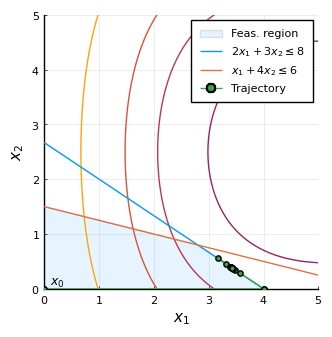

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [109]:
# Plotting

# Plotting the contours of the function optimised and the trajectory
f(x) = exp(-(x[1]-3)/2) + exp((4x[2] + x[1] - 20)/10) + exp((-4x[2] + x[1])/10)
# For validation
A = [2 3;
     1 4]
b = [8; 6]

n = 1000
x = range(-20,stop=20,length=n);
y = range(-20,stop=20,length=n);
z = [f([x[i],y[j]]) for j = 1:n, i = 1:n];

#Plot feasible region
plot(Shape([(0,0), (4,0), (2.8, 0.8), (0, 1.5)]), alpha = 0.1, label = "Feas. region")

# Plot function contours
contour!(x,y,z, # Change title accordingly
        levels = [0.5, 1, 1.5, 2, 2.5, 3, 4],
        xaxis = (L"$x_1$", (-0.0,5)),
        yaxis = (L"$x_2$", (-0.0,5)),
        clims = (0,5),
        cbar = false,
        legend = true,
        aspect_ratio = :equal)

# Plot feasible region
plot!(x, ((b[1] .- A[1,1] * x)./A[1,2]),
        #fill= (10,0.1),
        color = 1,
        label = L"$2x_1 + 3x_2 \leq 8$")

plot!(x, ((b[2] .- A[2,1] * x)./A[2,2]),
        #fill= (10,0.1),
        color = 2,
        label = L"$x_1 + 4x_2 \leq 6$")


# Plot trajectory
plot!(traj2[1,1:2], traj2[2,1:2], marker=:o, color = 3, label = "Trajectory")
annotate!(0.1, 0.1, text(L"$x_0$",9,:left))

plot!(traj2[1,:], traj2[2,:], marker=:o, color = 3, label = "")

savefig("FW_alliter_armijo.pdf")